# HW3

In [ ]:
packages<- c(
"dplyr",
"readr",
"tidyr",
"purrr",
"broom",
"magrittr",
"corrplot",
"caret",
"rpart",
"rpart.plot",
"e1071",
"torch",
"luz",
"ramify",
"keras"
)
sapply(packages, require, character.only=T)

     dplyr      readr      tidyr      purrr      broom   magrittr   corrplot 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE      FALSE 
     caret      rpart rpart.plot      e1071      torch        luz     ramify 
     FALSE       TRUE      FALSE      FALSE       TRUE       TRUE      FALSE 
     keras 
     FALSE 

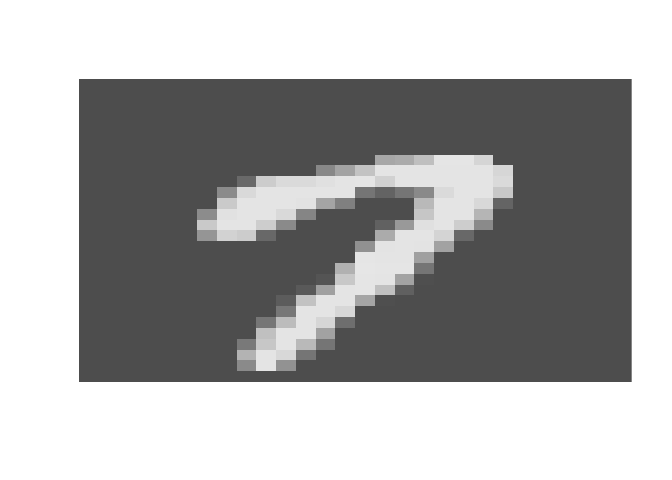

In [ ]:
library(tidyverse)
data = read.csv("image_data.csv",header = F)
change = lapply(asplit(data, 1), matrix, nrow= 28)
image(change[[1]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )

# 1.1

### 1

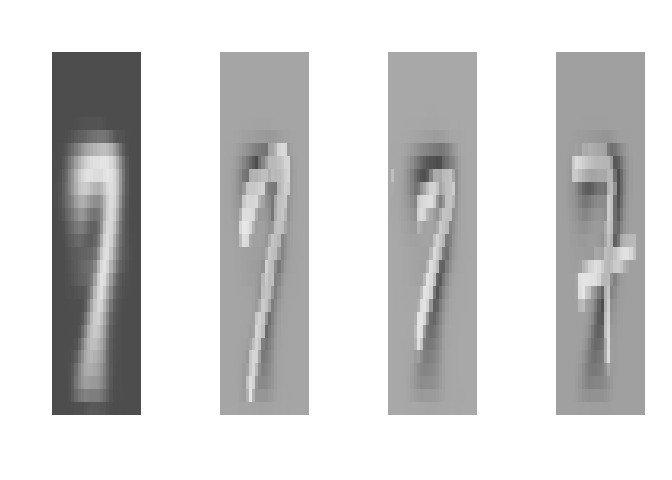

In [ ]:
par(mfrow=c(1,4))
# mean784 = colMeans(data) %>% matrix(nrow=28)
# image(mean784[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
mean784 = colMeans(data) 
image((mean784%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )

for (i in 1:3){
  changei = change[[i]] - mean784
  image(changei[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
  
}

### 2

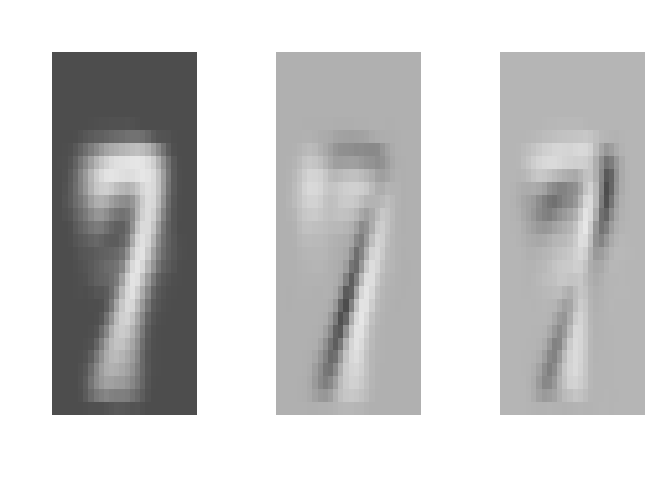

In [ ]:
xtx = crossprod(as.matrix(data)) * 1/784
ev = eigen(xtx)
par(mfrow=c(1,3))
for (i in 1:3){
  evi = ev$vectors[, i] %>% matrix(nrow=28)
  image(evi[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000)  )
}

### 3

In [ ]:
pca = prcomp(data)
evector25 = pca$rotation[,1:25]
dat1 = crossprod(as.matrix(data[1,]) %>% t, evector25)
dat1

        PC1       PC2       PC3       PC4      PC5       PC6       PC7
1 -2.371328 -4.630464 -4.300195 0.1366168 4.267409 -2.597558 0.3588868
        PC8      PC9       PC10       PC11       PC12      PC13       PC14
1 -1.402071 1.199345 -0.4513706 -0.3457885 -0.6438855 0.1522764 -0.2199022
       PC15      PC16      PC17       PC18      PC19       PC20      PC21
1 0.5601666 -0.175562 0.8828348 -0.3998254 0.2288568 -0.3852087 0.5441369
        PC22      PC23      PC24      PC25
1 -0.2404807 0.5112833 -0.332762 0.9666731

### 4

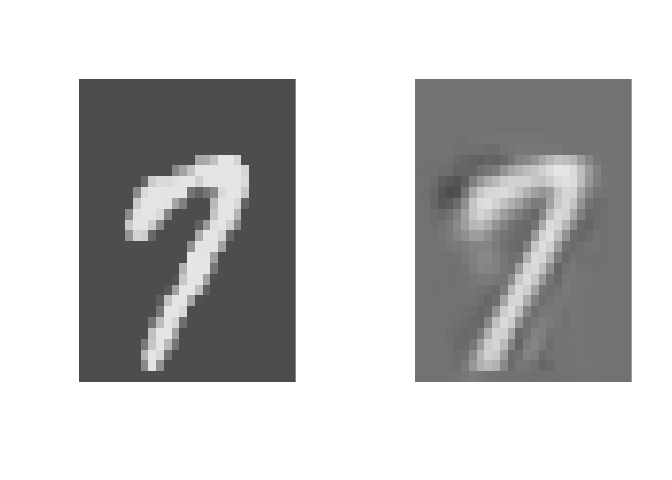

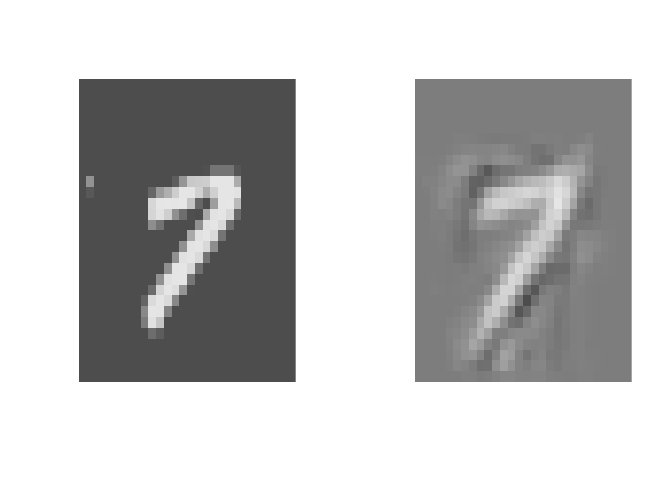

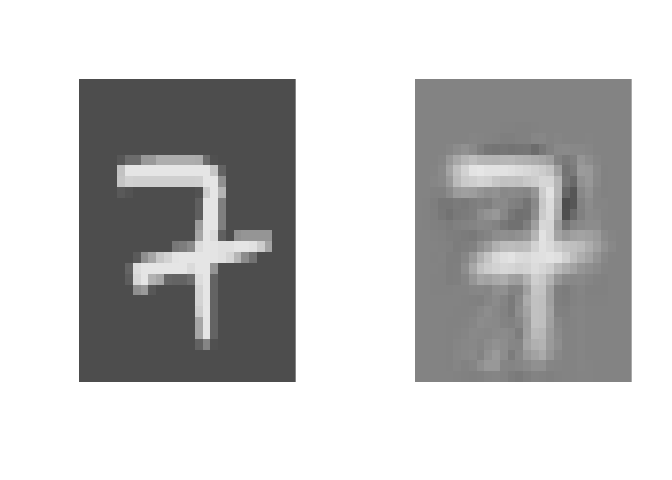

In [ ]:
score = pca$x
zjuj = crossprod(evector25 %>% t, score[, 1:25] %>% t) 
reconstruct = apply(zjuj,2,\(x) x+mean784) %>%  t
#zjuj[,1] + mean784 == reconstruct[,1]
for (i in 1:3){
  par(mfrow=c(1,2))
  image(change[[i]][,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
  image((reconstruct[i,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
}

### 1.2

When performing principal component analysis using $XX^T$ (covariance
matrix approach), the principal components capture the variability
within the observations (rows of the data matrix). Therefore, the
reconstruction obtained from the principal components represents the
original data in the observation space.

On the other hand, when using $X^TX$ (cross-product matrix approach),
the principal components capture the variability within the variables
(columns of the data matrix). Therefore, the reconstruction obtained
from the principal components represents the original data in the
variable space.

In practice, the reconstructions may differ in terms of their
interpretability and applicability to the problem at hand. The
reconstruction obtained from $XX^T$ may be more relevant if the goal is
to understand patterns and relationships among the observations, whereas
the reconstruction obtained from $X^TX$ may be more relevant if the
focus is on understanding the importance of variables or features in
explaining the variability of the data.

It’s important to note that both approaches aim to capture the maximum
amount of variance in the data, but they do so from different
perspectives (observations vs. variables), which can lead to different
reconstructions. The choice between the two approaches depends on the
specific characteristics of the data and the goals of the analysis.

In this case $XX^T$ will be more efficient since it is a 400x400 matrix,
smaller than the $X^TX$ (784x784).

### 1.2.2

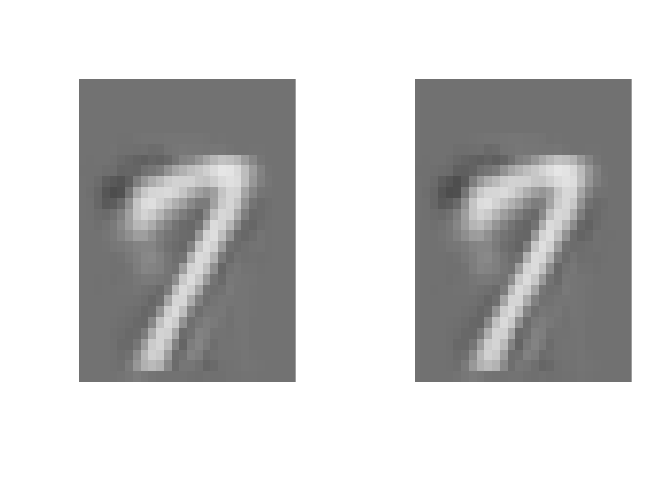

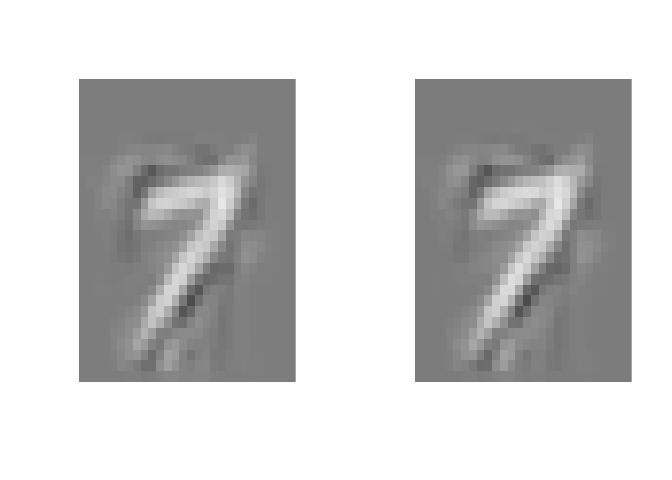

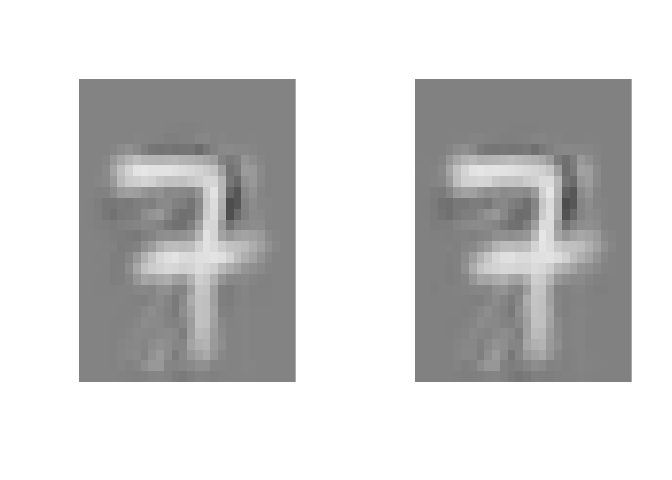

In [ ]:
xxt = as.matrix(data) %*% t(data)
mean784.2 = colMeans(t(data))

pca2 = prcomp(t(data))
evector25.2 = pca2$rotation[,1:25]

###
score2 = pca2$x
zjuj2 = crossprod(evector25.2 %>% t, score2[, 1:25] %>% t) 
reconstruct2 = apply(zjuj2,2,\(x) x+ mean784.2)
#zjuj[,1] + mean784 == reconstruct[,1]
for (i in 1:3){
  par(mfrow=c(1,2))
  image((reconstruct[i,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
  image((reconstruct2[i,]%>% matrix(nrow=28))[,28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000) )
}

### 1.2.4

I would say the two reconstructions are similar. This is a small
dataset. This is a dataset for hand written 7, so there is not a lot of
varaiblity among features(pixes) and data themselves.

# 2

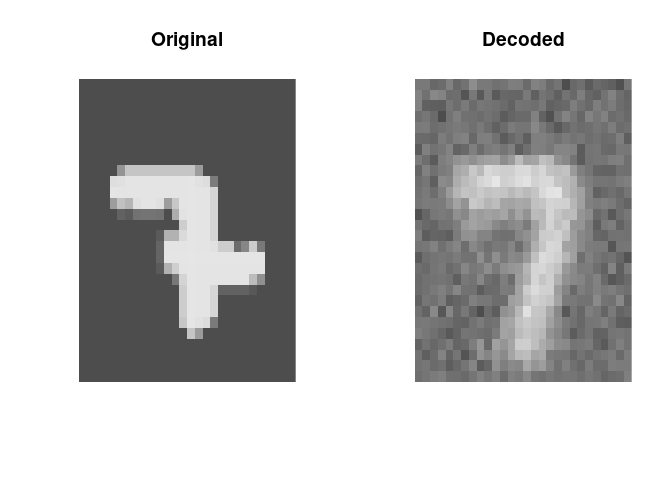

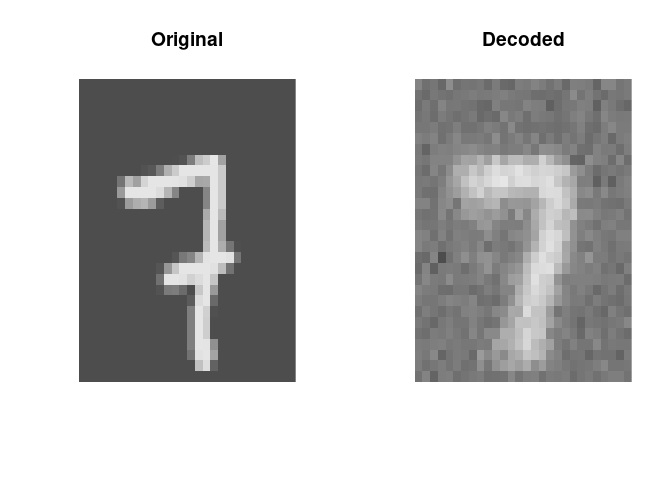

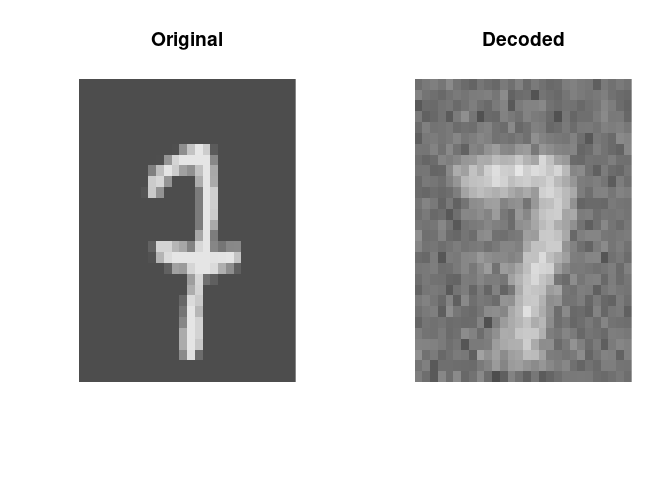

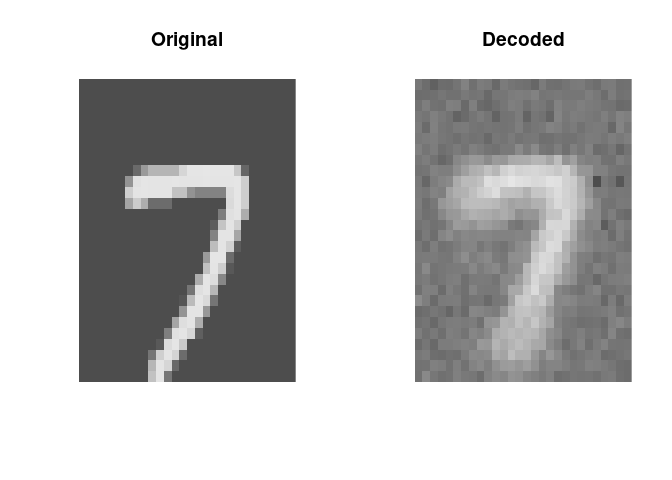

In [ ]:
library(torch)
library(luz)
library(abind)
library(tidyverse)
data = read.csv("image_data.csv",header = F) %>% data.frame
a = unlist(data)
dim(a) = c(400, 28, 28)
inputs = torch_tensor(a)

autoencoder <- nn_module(
  initialize = function(p, o) {
    self$encoder <- nn_sequential(
      nn_linear(p, o)
    )
    self$decoder <- nn_sequential(
      nn_linear(o, p)
    )
  },
  forward = function(x) {
    x %>%
      torch_reshape(c(-1, 28 * 28)) %>% 
      self$encoder() %>%
      self$decoder() %>% 
      torch_reshape(c(-1, 28, 28))
  },
  predict = function(x) {
    x %>% 
      torch_reshape(c(-1, 28 * 28)) %>% 
      self$encoder()     
  }
)

ae_fit <- autoencoder %>%
  setup(
    loss = nn_mse_loss(),
    optimizer = optim_adam
  ) %>%
  set_hparams(
    p=28*28, o=25
  ) %>%
  set_opt_hparams(
    lr=1e-3
  ) %>%
  fit(
    data = list(
      inputs, 
      inputs # targets are the same as inputs
    ),
    epochs=10,
    verbose=TRUE
    )
plot_image = \(x) image(t(x)[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000))
#plot_image(inputs[1] %>% as_array)
set.seed(100)
par(mfrow=c(4, 2))
for(k in 1:4){
  i <- sample(1:400, 1)
  input <- inputs[i]
  output <- ae_fit$model$forward(inputs[i:i])[1]
  par(mfrow=c(1, 2))
  plot_image(inputs[i] %>% as_array %>% t)
  title("Original")
  
  plot_image(output %>% as_array %>% t)
  title("Decoded")
}

Linear encoder decoder did a worse job than pca.

### 2.2 Nonlinear Autoencoder

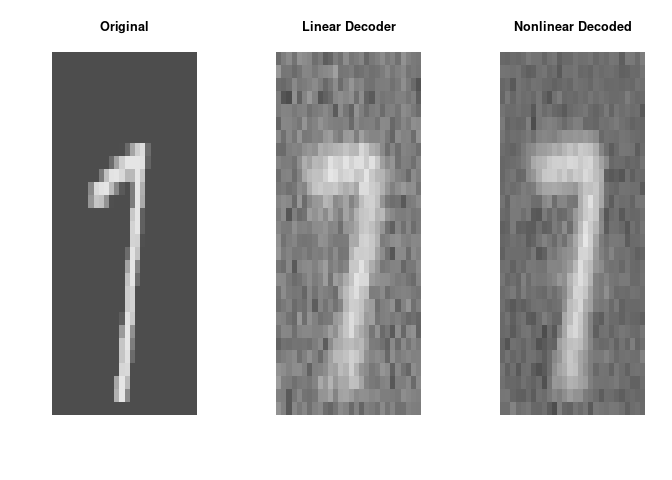

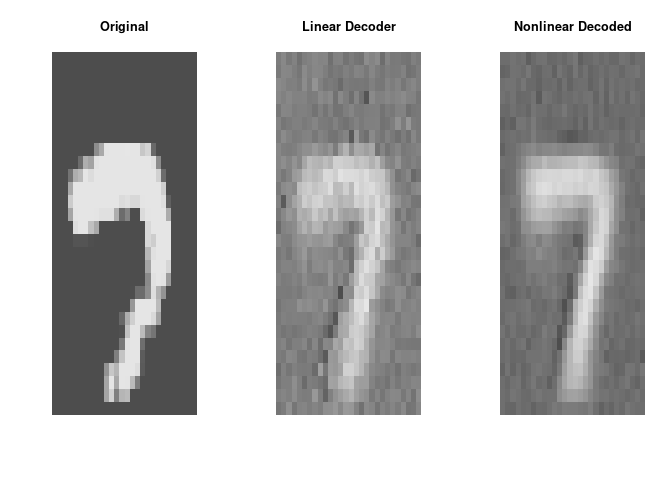

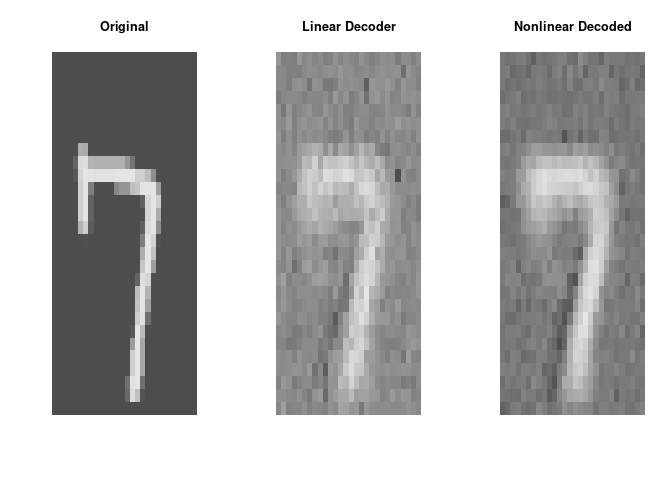

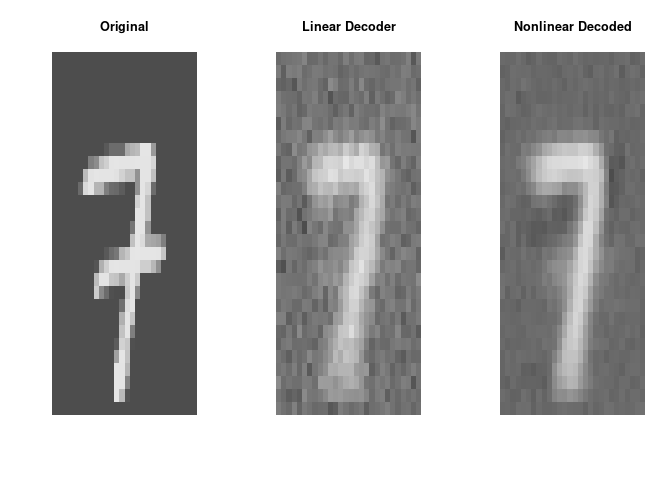

In [ ]:
autoencoder2 <- nn_module(
  initialize = function(p, q1, o) {
    self$encoder <- nn_sequential(
      nn_linear(p, q1), nn_relu(),
      nn_linear(q1, o)
    )
    self$decoder <- nn_sequential(
      nn_linear(o, q1), nn_relu(),
      nn_linear(q1, p)
    )
  },
  forward = function(x) {
    x %>%
      torch_reshape(c(-1, 28 * 28)) %>% 
      self$encoder() %>%
      self$decoder() %>% 
      torch_reshape(c(-1, 28, 28))
  },
  predict = function(x) {
    x %>% 
      torch_reshape(c(-1, 28 * 28)) %>% 
      self$encoder()     
  }
)

ae_fit2 <- autoencoder2 %>%
  setup(
    loss = nn_mse_loss(),
    optimizer = optim_adam
  ) %>%
  set_hparams(
    p=28*28, q1 = 64, o=25
  ) %>%
  set_opt_hparams(
    lr=1e-3
  ) %>%
  fit(
    data = list(
      inputs, 
      inputs # targets are the same as inputs
    ),
    epochs=10,
    verbose=TRUE
  )

par(mfrow=c(4, 2))
for(k in 1:4){
  i <- sample(1:400, 1)
  input <- inputs[i]
  output1 <- ae_fit$model$forward(inputs[i:i])[1]

  output2 <- ae_fit2$model$forward(inputs[i:i])[1]
  par(mfrow=c(1, 3))
  plot_image(inputs[i] %>% as_array %>% t)
  title("Original")
  
  plot_image(output1 %>% as_array %>%  t)
  title("Linear Decoder")
  
  plot_image(output2 %>% as_array %>% t)
  title("Nonlinear Decoded")
}

The non linear one is doing a better job than the linear one.

# 3

Mode collapse: This occurs when the generator collapses to generating a
limited set of samples, ignoring the diversity present in the training
data. As a result, the generator produces similar samples(all cats).